In [3]:
import statsmodels.formula.api as smf    # for OLS regression
import pylab as pl
import pandas as pd
import numpy as np
import json
from getcsv import getCitiBikeCSV
import urllib2 

import scipy.stats

import os

import json
s = json.load( open("fbb_matplotlibrc.json") )
pl.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
os.getenv('PUIDATA')

'C:\\Users\\sddz0\\PUI2017\\'

In [5]:
datestring1 = '201506'
getCitiBikeCSV(datestring1)
datestring2 = '201601'
getCitiBikeCSV(datestring2)

('Downloading', '201506')
WARNING!!! something is wrong: the file is not there!
('Downloading', '201601')
WARNING!!! something is wrong: the file is not there!


In [3]:
cb2015 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring1 + '-citibike-tripdata.csv')
cb2016 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')

In [4]:
cb2015.drop([u'tripduration', u'starttime', u'stoptime', 
       u'start station name',
       u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'], axis = 1, inplace = True)

cb2016.drop([u'tripduration', u'starttime', u'stoptime', 
       u'start station name',
       u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'], axis = 1, inplace = True)

In [5]:
def readIncomeXls(url):
    return pd.read_excel(url, header=3, index_col="ZIP\ncode [1]" , skip_footer=1)

In [6]:
url = "https://www.irs.gov/pub/irs-soi/14zp33ny.xls"
incomebyzip = readIncomeXls(url) 


In [7]:
zipincome = pd.DataFrame()
for i in incomebyzip.index.unique():
    if i is np.nan: continue
    elif type(incomebyzip.loc[i]["Adjusted gross income (AGI) [3]"]) is np.float64: continue
    else:
        zipincome.loc[i,'income'] = incomebyzip.loc[i]["Adjusted gross income (AGI) [3]"].iloc[0]
        zipincome.loc[i,'N'] = incomebyzip.loc[i]["Number of returns"].iloc[0]
        zipincome.loc[i,'Ndepend'] = incomebyzip.loc[i]["Number of dependents"].iloc[0]
        zipincome.loc[i,'Njoint'] = incomebyzip.loc[i]["Number of joint returns"].iloc[0]

In [8]:
zipincome['incomePC'] = zipincome.loc[:,'income'] /\
                        (zipincome.loc[:,'N'] + 
                         zipincome.loc[:,'Ndepend'] +
                         zipincome.loc[:,'Njoint'])

In [11]:
zipincome.reset_index(inplace=True)

In [13]:
zipincome.rename(columns={'index':'zipcodes'}, inplace=True)

In [15]:
cb = pd.concat([cb2015, cb2016], ignore_index=True)

In [16]:
print cb2015.shape
print cb2016.shape
print cb.shape

(941219, 3)
(509478, 3)
(1450697, 3)


In [17]:
#Create a dataframe with station id, latitude, longitude and also zip of all the unique station id's in the dataframe
df_zip = pd.DataFrame()
for id in cb['start station id'].unique():
    df_zip.loc[id,'lat'] = float(cb[cb['start station id'] == id]['start station latitude'].unique()[0])
    df_zip.loc[id,'lon'] = float(cb[cb['start station id'] == id]['start station longitude'].unique()[0])

In [19]:
df_zip.reset_index(inplace=True)

In [20]:
# Using reverse geocoding, getting the zipcode from the json received by passing the latitude and longitude - I found this API
#from google search, but I am unable to find the website again to cite it!!
for i in range(len(df_zip)):
    url = "http://nominatim.openstreetmap.org/reverse?format=json&lat={0}\
&lon={1}&zoom=18&addressdetails=1".format(df_zip['lat'][i],df_zip['lon'][i])
    response = urllib2.urlopen(url)
    data = response.read().decode("utf-8")
    info = json.loads(data)
    df_zip.loc[i,'zip'] = int(filter(str.isdigit, str(info['address']['postcode'])))

In [22]:
df_zip.rename(columns={"index": "start station id"}, inplace=True)

In [23]:
#merge the dataframes
cb = pd.merge(cb,df_zip,on='start station id')

In [25]:
cbgroup = pd.DataFrame()
cbgroup = cb.groupby(['zip']).count()

In [26]:
cbgroup = cbgroup[cbgroup.index > 10000]
cbgroup = cbgroup[cbgroup.index < 100000]

In [28]:
cbgroup.reset_index(inplace=True)
cbgroup.rename(columns={'zip':'zipcodes'}, inplace=True)

In [29]:
cbgroup.drop([u'start station latitude',u'start station longitude', u'lat', u'lon'], axis = 1, inplace =True)
cbgroup.rename(columns={'start station id':'nrides'}, inplace = True)

In [30]:
cbgroup.head(5)

,zipcodes,nrides
0,10001.0,85779
1,10002.0,78501
2,10003.0,110598
3,10004.0,9851
4,10005.0,19778


In [31]:
cbincome = pd.merge(zipincome, cbgroup,on='zipcodes')

In [32]:
cbincome.head(5)

,zipcodes,income,N,Ndepend,Njoint,incomePC,nrides
0,10001,2363960.0,14080.0,3250.0,2410.0,119.754813,85779
1,10002,2215542.0,43370.0,19160.0,11040.0,30.114748,78501
2,10003,6910992.0,29810.0,4790.0,5460.0,172.516026,110598
3,10004,925417.0,2540.0,1130.0,840.0,205.192239,9851
4,10005,5545849.0,5890.0,1340.0,1340.0,647.123571,19778


# Analysis

In [33]:
lm = smf.ols(formula = 'nrides ~ income', data = cbincome).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 nrides   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.606
Date:                Tue, 25 Oct 2016   Prob (F-statistic):             0.0635
Time:                        17:41:39   Log-Likelihood:                -600.88
No. Observations:                  51   AIC:                             1206.
Df Residuals:                      49   BIC:                             1210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.654e+04   6787.658      2.437      0.0

# The above summary shows that the ridership and AGI are linearly correlated with r = 0.065

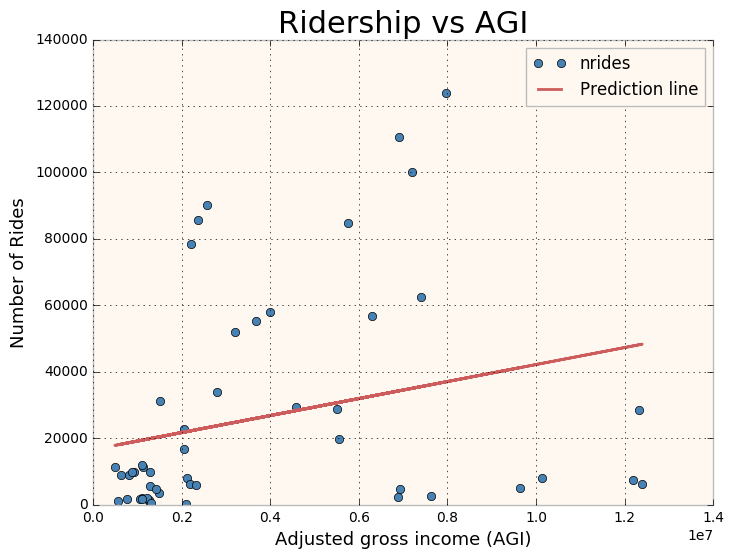

In [34]:
fig = pl.figure(figsize=(8,6))
pl.plot(cbincome.income, cbincome.nrides, 'o')
pl.plot(cbincome.income, lm.predict(cbincome), label = 'Prediction line')
pl.title('Ridership vs AGI', fontsize = 22)
pl.xlabel('Adjusted gross income (AGI)', fontsize = 13)
pl.ylabel('Number of Rides', fontsize = 13)
pl.legend(loc='best', fontsize = 12)

# Figure 1: The plot shows the relationship between ridership and Adjusted Gross Income(AGI). The plot shows that a linear relation is present between them and the prediction line shows the same, however there are some outliers which are influencing the prediction line

# Removing Outliers
## The points at 1.2e7 are influencing the prediction line towards them, so we will remove those points and try to fit the line through the new data 

In [35]:
sorted(cbincome.income, reverse=True)[:3]

[12398465.0, 12325088.0, 12181504.0]

#### We are removing the top 2 high value points i.e points with income 12398465.0, 12325088.0

In [36]:
cbincome1 = cbincome[ cbincome.income < 12325088.0 ]

In [37]:
lm1 = smf.ols(formula = 'nrides ~ income', data = cbincome1).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                 nrides   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     6.165
Date:                Tue, 25 Oct 2016   Prob (F-statistic):             0.0167
Time:                        17:42:17   Log-Likelihood:                -576.83
No. Observations:                  49   AIC:                             1158.
Df Residuals:                      47   BIC:                             1161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.332e+04   7011.484      1.900      0.0

# The above summary shows that after removing the outliers, the linear relationship has imporoved than before, r =0.116

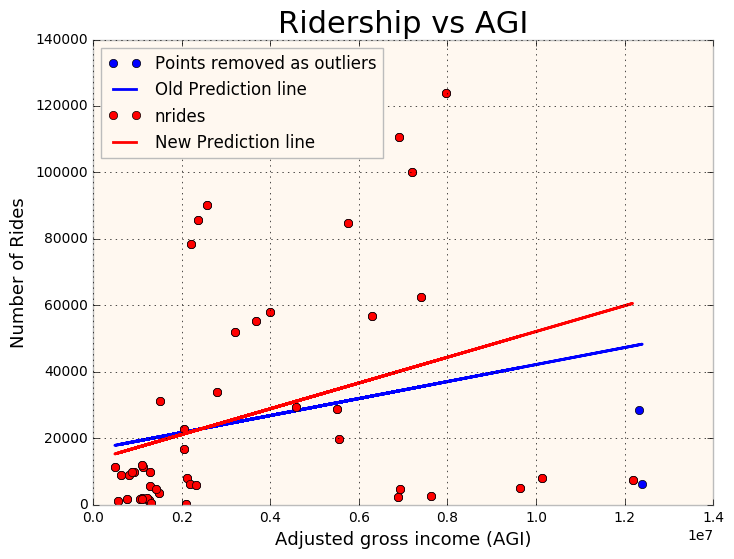

In [38]:
fig = pl.figure(figsize=(8,6))
pl.plot(cbincome.income, cbincome.nrides, 'o', color = 'blue', label = 'Points removed as outliers')
pl.plot(cbincome.income, lm.predict(cbincome), label = 'Old Prediction line', color = 'blue')

pl.plot(cbincome1.income, cbincome1.nrides, 'o', color = 'red')
pl.plot(cbincome1.income, lm1.predict(cbincome1), label = 'New Prediction line', color = 'red')

pl.title('Ridership vs AGI', fontsize = 22)
pl.xlabel('Adjusted gross income (AGI)', fontsize = 13)
pl.ylabel('Number of Rides', fontsize = 13)
pl.legend(loc='best', fontsize = 12)

# Figure 2: The plot shows the old and new prediction line. The blue points are the outliers which were removed in the new data. As it can be seen, these points were streching the prediction line towards them

In [39]:
cbincome1.loc[:,'income2'] = cbincome1.loc[:,'income'] * cbincome1.loc[:,'income']

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
lm2 = smf.ols(formula = 'nrides ~ income + income2', data = cbincome1).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                 nrides   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     11.52
Date:                Tue, 25 Oct 2016   Prob (F-statistic):           8.81e-05
Time:                        17:42:54   Log-Likelihood:                -569.90
No. Observations:                  49   AIC:                             1146.
Df Residuals:                      46   BIC:                             1151.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.248e+04   9063.280     -1.377      0.1

# The above summary shows that after fitting through a 2nd degree polynomial, the fit has improved, r =0.334

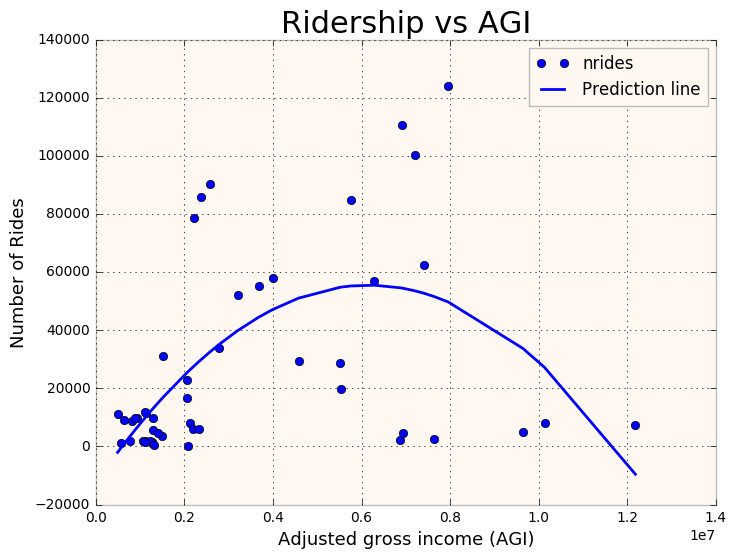

In [41]:
fig = pl.figure(figsize=(8,6))
pl.plot(cbincome1.income, cbincome1.nrides, 'o', color = 'blue')
pl.plot((sort(cbincome1.income)), lm2.predict(cbincome1.sort_values('income')), label = 'Prediction line', color = 'blue')

pl.title('Ridership vs AGI', fontsize = 22)
pl.xlabel('Adjusted gross income (AGI)', fontsize = 13)
pl.ylabel('Number of Rides', fontsize = 13)
pl.legend(loc='best', fontsize = 12)

# Figure 3: The plot shows that the 2nd degree polynomial which is fitted through the data. It seems that at high incomes the rides have reduced, this maybe because the rich people use their own transport instead of using the citibike

In [42]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [43]:
errornride = np.sqrt(cbincome1.nrides)
errorincome = np.sqrt(cbincome1.income)
error_tot = np.sqrt(errorincome**2 + errornride**2 )

In [44]:
print ("Ridership vs Income chi square with independant variable error only: %.2f"%\
       chi2(cbincome1.nrides, lm1.predict(), 
            errors = errorincome))

print ("Ridership vs Income 2nd degree fit chi square with independant variable error only: %.2f"%\
       chi2(cbincome1.nrides, lm2.predict(), 
            errors = errorincome))

Ridership vs Income chi square with independant variable error only: 13093.32
Ridership vs Income 2nd degree fit chi square with independant variable error only: 9606.25


In [45]:
print ("Ridership vs Income chi square with dependant variable error only: %.2f"%\
       chi2(cbincome1.nrides, lm1.predict(), 
            errors = errornride))

print ("Ridership vs Income 2nd degree fit chi square with dependant variable error only: %.2f"%\
       chi2(cbincome1.nrides, lm2.predict(), 
            errors = errornride))

Ridership vs Income chi square with dependant variable error only: 11269711.76
Ridership vs Income 2nd degree fit chi square with dependant variable error only: 12929285.59


In [46]:
print ("Ridership vs Income chi square with both variable error only: %.2f"%\
       chi2(cbincome1.nrides, lm1.predict(), 
            errors = error_tot))

print ("Ridership vs Income 2nd degree fit chi square with both variable error only: %.2f"%\
       chi2(cbincome1.nrides, lm2.predict(), 
            errors = error_tot))

Ridership vs Income chi square with both variable error only: 12865.30
Ridership vs Income 2nd degree fit chi square with both variable error only: 9431.03


# The chi sq (residuals with errors) is affected by the errors are calculated. I have assumed all quantities suffer from only poisson statistics. I di not know what the correct statistic for income per zipcode is, Poisson is always an underestimation. It is appropriate for the number of rides, because it is literally just counting the rides, but there are going to be statistical errors caused by humans and other errors as well in the income data which is not accounted for.

# If the errors were calculated correctly the chi squares would be reliable, but as it is they are not!

# Alpha = 0.05

Null Hypothesis: The restricted model is better

# Comparing using LR test

In [47]:
print ("LR : ", -2 * (lm1.llf - (lm2.llf)))
print ("LR from statsmodels:", lm2.compare_lr_test(lm1))

('LR : ', 13.852335863947474)
('LR from statsmodels:', (13.852335863947474, 0.00019775077294982872, 1.0))


# The P-value is less than 0.05, we can reject the null hypothesis with statistical significance of 95%, i.e our 2nd degree polynomial is a better fit for the data

In [48]:
lm3 = smf.ols(formula = 'nrides ~ incomePC', data = cbincome1).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                 nrides   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.396
Date:                Tue, 25 Oct 2016   Prob (F-statistic):              0.243
Time:                        17:44:37   Log-Likelihood:                -579.13
No. Observations:                  49   AIC:                             1162.
Df Residuals:                      47   BIC:                             1166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.038e+04   7069.858      2.882      0.0

# The above summary shows that income per person and reidership have linear reltion with r =0.029

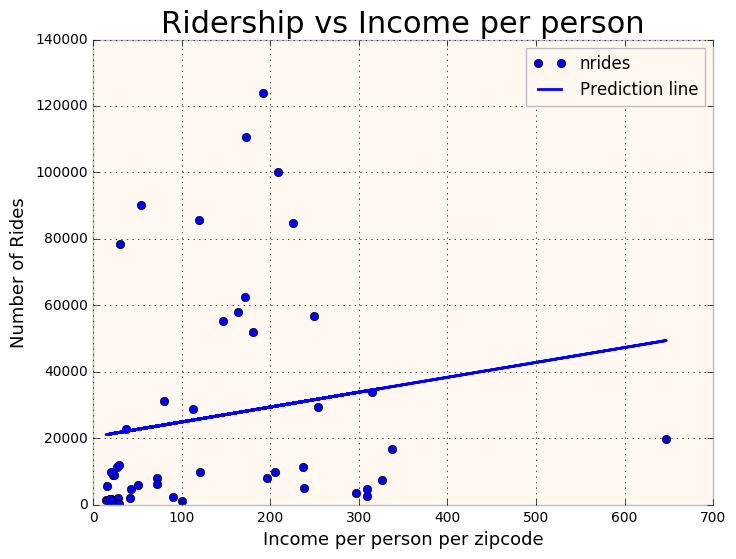

In [49]:
fig = pl.figure(figsize=(8,6))
pl.plot(cbincome1.incomePC, cbincome1.nrides, 'o', color = 'blue')
pl.plot(cbincome1.incomePC, lm3.predict(cbincome1), label = 'Prediction line', color = 'blue')

pl.title('Ridership vs Income per person', fontsize = 22)
pl.xlabel('Income per person per zipcode', fontsize = 13)
pl.ylabel('Number of Rides', fontsize = 13)
pl.legend(loc='best', fontsize = 12)

# Figure 4: The plot shows the predicted line for number of riders in respect to the income per person. The high influencing point at 700 is affecting the prediction.

In [50]:
sorted(cbincome1.incomePC, reverse=True)[:3]

[647.12357059509918, 337.24102141680396, 325.88293204922417]

#### We are removing the high leverage value points i.e points with income per person: 647.12357059509918

In [51]:
cbincome2 = cbincome1[ cbincome1.incomePC <  647.12357059509918 ]

In [52]:
lm4 = smf.ols(formula = 'nrides ~ incomePC', data = cbincome2).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                 nrides   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.568
Date:                Tue, 25 Oct 2016   Prob (F-statistic):              0.116
Time:                        17:45:15   Log-Likelihood:                -567.19
No. Observations:                  48   AIC:                             1138.
Df Residuals:                      46   BIC:                             1142.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.723e+04   7614.309      2.262      0.0

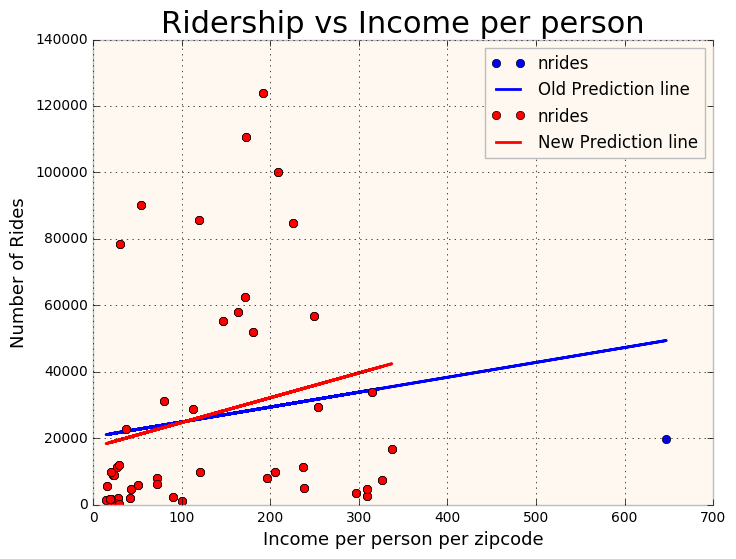

In [53]:
fig = pl.figure(figsize=(8,6))
pl.plot(cbincome1.incomePC, cbincome1.nrides, 'o', color = 'blue')
pl.plot(cbincome1.incomePC, lm3.predict(cbincome1), label = 'Old Prediction line', color = 'blue')

pl.plot(cbincome2.incomePC, cbincome2.nrides, 'o', color = 'red')
pl.plot(cbincome2.incomePC, lm4.predict(cbincome2), label = 'New Prediction line', color = 'red')

pl.title('Ridership vs Income per person', fontsize = 22)
pl.xlabel('Income per person per zipcode', fontsize = 13)
pl.ylabel('Number of Rides', fontsize = 13)
pl.legend(loc='best', fontsize = 12)

# Figure 5: The plot shows the predicted line for number of riders in respect to the income per person. The high influencing point at 700 is affecting the prediction as seen with the old prediction line, however, linear is not the perfect fit, maybe a 2nd degree polynomial will be a better fit to the data